<a href="https://colab.research.google.com/github/zetaqubit/udlbook/blob/main/Notebooks/Chap15/15_1_GAN_Toy_Example_soln.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 15.1: GAN Toy example**

This notebook investigates the GAN toy example as illustrated in figure 15.1 in the book.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Get a batch of real data.  Our goal is to make data that looks like this.
def get_real_data_batch(n_sample):
  np.random.seed(0)
  x_true = np.random.normal(size=(1,n_sample)) + 7.5
  return x_true

Define our generator.  This takes a standard normally-distributed latent variable $z$ and adds a scalar $\theta$ to this, where $\theta$ is the single parameter of this generative model according to:

\begin{equation}
x_i = z_i + \theta.
\end{equation}

Obviously this model can generate the family of Gaussian distributions with unit variance, but different means.

In [3]:
# This is our generator -- takes the single parameter theta
# of the generative model and generates n samples
def generator(z, theta):
    x_gen = z + theta
    return x_gen

Now, we define our discriminator.  This is a simple logistic regression model (1D linear model passed through sigmoid) that returns the probability that the data is real

In [4]:
# Define our discriminative model

# Logistic sigmoid, maps from [-infty,infty] to [0,1]
def sig(data_in):
  return  1.0 / (1.0+np.exp(-data_in))

# Discriminator computes y
def discriminator(x, phi0, phi1):
  return sig(phi0 + phi1 * x)

In [5]:
# Draws a figure like Figure 15.1a
def draw_data_model(x_real, x_syn, phi0=None, phi1=None):
  fix, ax = plt.subplots();

  for x in x_syn:
    ax.plot([x,x],[0,0.33],color='#f47a60')
  for x in x_real:
    ax.plot([x,x],[0,0.33],color='#7fe7dc')

  if phi0 is not None:
    x_model = np.arange(0,10,0.01)
    y_model = discriminator(x_model, phi0, phi1)
    ax.plot(x_model, y_model,color='#dddddd')
  ax.set_xlim([0,10])
  ax.set_ylim([0,1])


  plt.show()

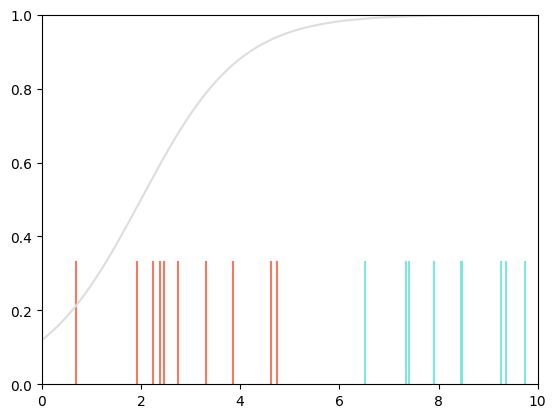

In [6]:
# Get data batch
x_real = get_real_data_batch(10)

# Initialize generator and synthesize a batch of examples
theta = 3.0
np.random.seed(1)
z = np.random.normal(size=(1,10))
x_syn = generator(z, theta)

# Initialize discriminator model
phi0 = -2
phi1 = 1

draw_data_model(x_real, x_syn, phi0, phi1)

You can see that the synthesized (orange) samples don't look much like the real (cyan) ones, and the initial model to discriminate them (gray line represents probability of being real) is pretty bad as well.

Let's deal with the discriminator first.  Let's define the loss

In [7]:
# Discriminator loss
def compute_discriminator_loss(x_real, x_syn, phi0, phi1):

  # TODO -- compute the loss for the discriminator
  # Run the real data and the synthetic data through the discriminator
  # Then use the standard binary cross entropy loss with the y=1 for the real samples
  # and y=0 for the synthesized ones.
  # Replace this line
  y_real_pred = discriminator(x_real, phi0, phi1)
  y_syn_pred = discriminator(x_syn, phi0, phi1)
  loss = -(np.log(y_real_pred).sum() + np.log(1 - y_syn_pred).sum())
  return loss

In [8]:
# Test the loss
loss = compute_discriminator_loss(x_real, x_syn, phi0, phi1)
print("True Loss = 13.814757170851447, Your loss=", loss )

True Loss = 13.814757170851447, Your loss= 13.814757170851447


In [9]:
# Gradient of loss (cheating, using finite differences)
def compute_discriminator_gradient(x_real, x_syn, phi0, phi1):
  delta = 0.0001;
  loss1 = compute_discriminator_loss(x_real, x_syn, phi0, phi1)
  loss2 = compute_discriminator_loss(x_real, x_syn, phi0+delta, phi1)
  loss3 = compute_discriminator_loss(x_real, x_syn, phi0, phi1+delta)
  dl_dphi0 = (loss2-loss1) / delta
  dl_dphi1 = (loss3-loss1) / delta

  return dl_dphi0, dl_dphi1

# This routine performs gradient descent with the discriminator
def update_discriminator(x_real, x_syn, n_iter, phi0, phi1):

  # Define learning rate
  alpha = 0.01

  # Get derivatives
  print("Initial discriminator loss = ", compute_discriminator_loss(x_real, x_syn, phi0, phi1))
  for iter in range(n_iter):
    # Get gradient
    dl_dphi0, dl_dphi1 = compute_discriminator_gradient(x_real, x_syn, phi0, phi1)
    # Take a gradient step downhill
    phi0 = phi0 - alpha * dl_dphi0 ;
    phi1 = phi1 - alpha * dl_dphi1 ;

  print("Final Discriminator Loss= ", compute_discriminator_loss(x_real, x_syn, phi0, phi1))

  return phi0, phi1

Initial parameters (phi0,phi1) -2 1
Initial discriminator loss =  13.814757170851447
Final Discriminator Loss=  3.7329024780298656
Final parameters (phi0,phi1) -3.5540834577198126 0.7143290523579306


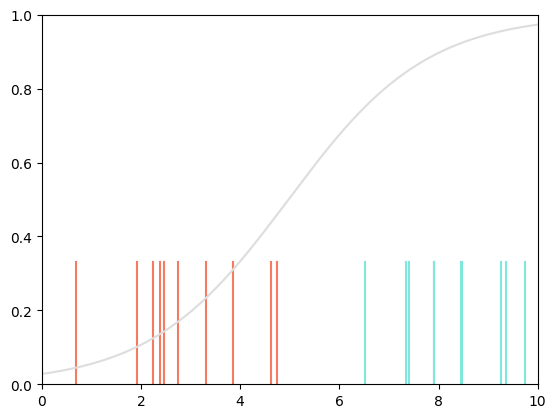

In [10]:
# Let's update the discriminator (sigmoid curve)
n_iter = 100
print("Initial parameters (phi0,phi1)", phi0, phi1)
phi0, phi1 = update_discriminator(x_real, x_syn, n_iter, phi0, phi1)
print("Final parameters (phi0,phi1)", phi0, phi1)
draw_data_model(x_real, x_syn, phi0, phi1)

Now let's update the generator

In [13]:
def compute_generator_loss(z, theta, phi0, phi1):
  # TODO -- Run the generator on the latent variables z with the parameters theta
  # to generate new data x_syn
  # Then run the discriminator on the new data to get the probability of being real
  # The loss is the total negative log probability of being synthesized (i.e. of not being real)
  # Replace this code
  x_syn = generator(z, theta)
  p_real = discriminator(x_syn, phi0, phi1)
  loss = -np.log(1 - p_real).sum()


  return loss

In [14]:
# Test generator loss to check you have it correct
loss = compute_generator_loss(z, theta, -2, 1)
print("True Loss = 13.78437035945412, Your loss=", loss )

True Loss = 13.78437035945412, Your loss= 13.78437035945412


In [15]:
def compute_generator_gradient(z, theta, phi0, phi1):
  delta = 0.0001
  loss1 = compute_generator_loss(z,theta, phi0, phi1) ;
  loss2 = compute_generator_loss(z,theta+delta, phi0, phi1) ;
  dl_dtheta = (loss2-loss1)/ delta
  return dl_dtheta

def update_generator(z, theta, n_iter, phi0, phi1):
    # Define learning rate
    alpha = 0.02

    # Get derivatives
    print("Initial generator loss = ", compute_generator_loss(z, theta, phi0, phi1))
    for iter in range(n_iter):
      # Get gradient
      dl_dtheta = compute_generator_gradient(x_real, x_syn, phi0, phi1)
      # Take a gradient step (uphill, since we are trying to make synthesized data less well classified by discriminator)
      theta = theta + alpha * dl_dtheta ;

    print("Final generator loss = ", compute_generator_loss(z, theta, phi0, phi1))
    return theta


Theta before 3.0
Initial generator loss =  2.602721236071937
Final generator loss =  5.591742644076854
Theta after 4.387548766643931


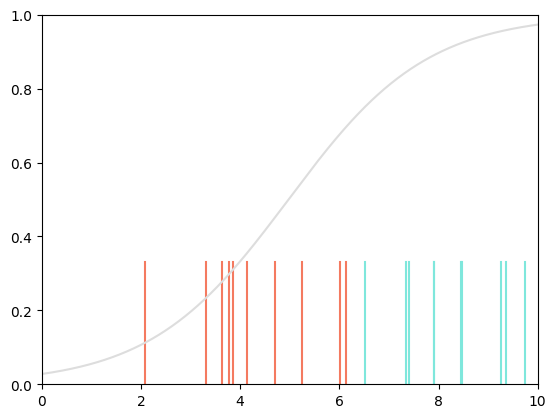

In [16]:
n_iter = 10
theta = 3.0
print("Theta before", theta)
theta = update_generator(z, theta, n_iter, phi0, phi1)
print("Theta after", theta)

x_syn = generator(z,theta)
draw_data_model(x_real, x_syn, phi0, phi1)

Final parameters (phi0,phi1) -2 1


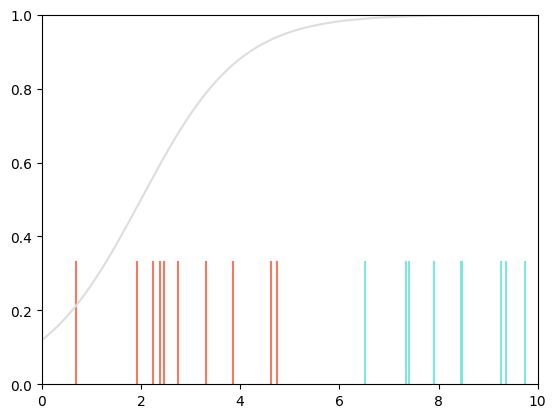

Updating discriminator
Initial discriminator loss =  13.814757170851447
Final Discriminator Loss=  2.318847463522516


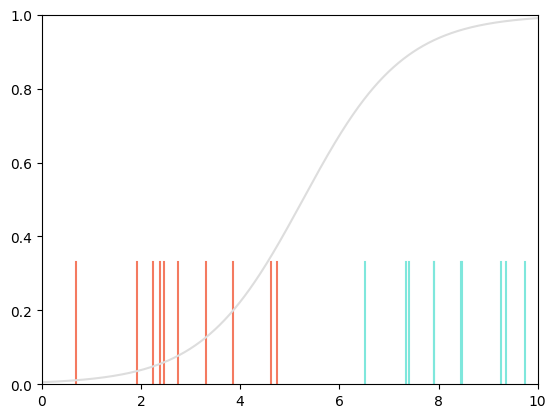

Updating generator
Initial generator loss =  1.5508571592285103
Final generator loss =  2.139699135998328


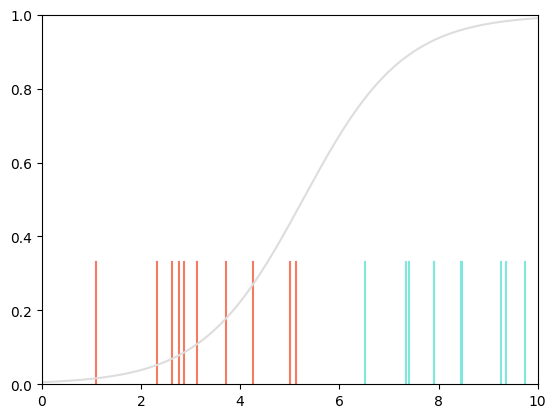

Updating discriminator
Initial discriminator loss =  2.9076894402923332
Final Discriminator Loss=  2.0131437935077647


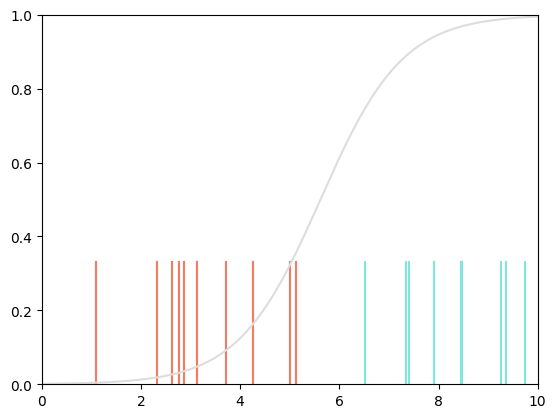

Updating generator
Initial generator loss =  1.2741174406558837
Final generator loss =  2.0538896618028617


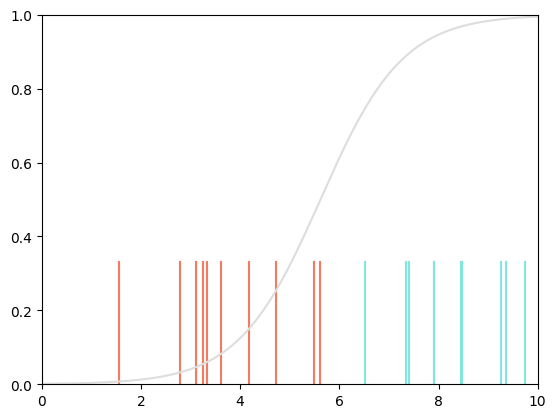

Updating discriminator
Initial discriminator loss =  2.7929160146547427
Final Discriminator Loss=  2.2294324769807496


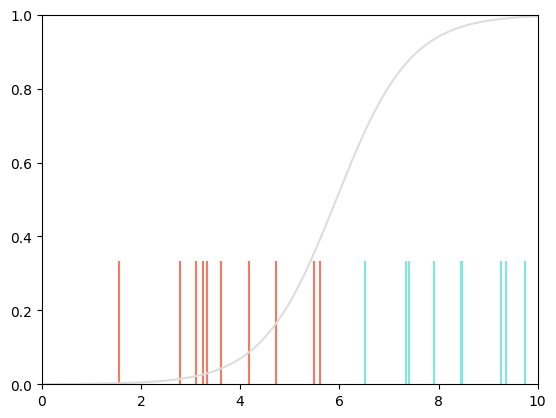

Updating generator
Initial generator loss =  1.347285471538007
Final generator loss =  2.3905793985867514


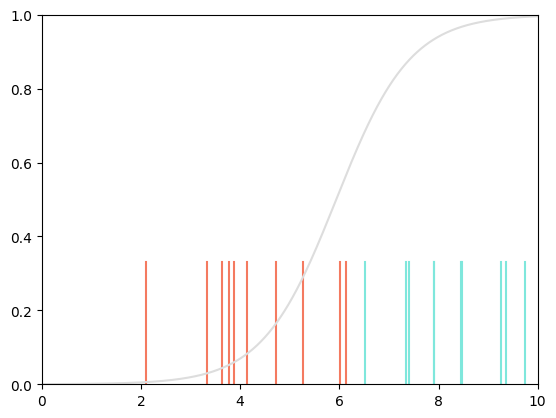

Updating discriminator
Initial discriminator loss =  3.2727264040294943
Final Discriminator Loss=  2.8094147141995136


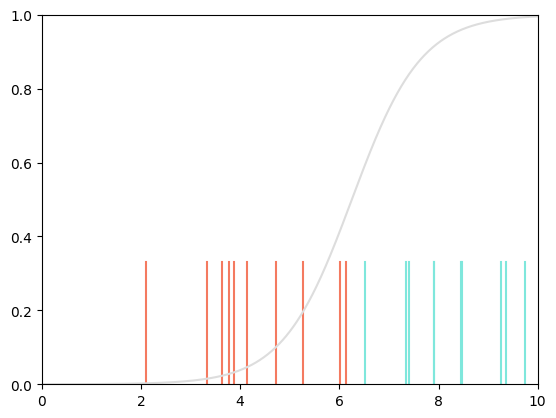

Updating generator
Initial generator loss =  1.6297834200680281
Final generator loss =  3.032739257884005


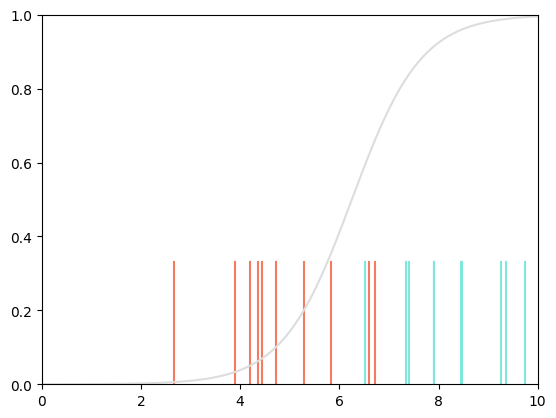

Updating discriminator
Initial discriminator loss =  4.212370552015491
Final Discriminator Loss=  3.8048725664877248


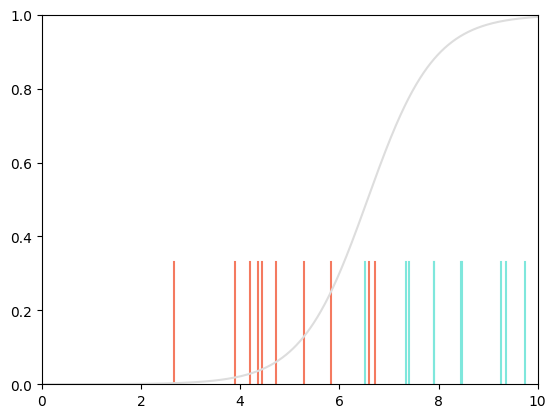

Updating generator
Initial generator loss =  2.1310870347093887
Final generator loss =  3.9803072388023883


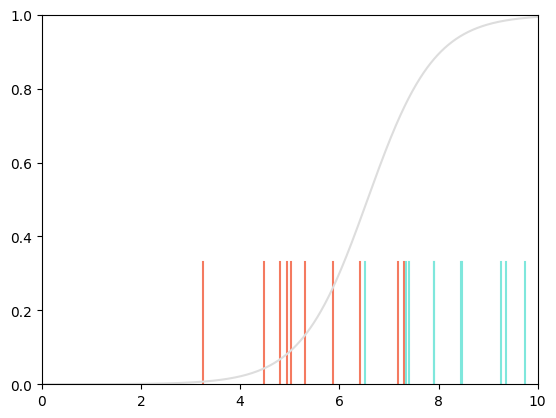

Updating discriminator
Initial discriminator loss =  5.654092770580725
Final Discriminator Loss=  5.30368974050965


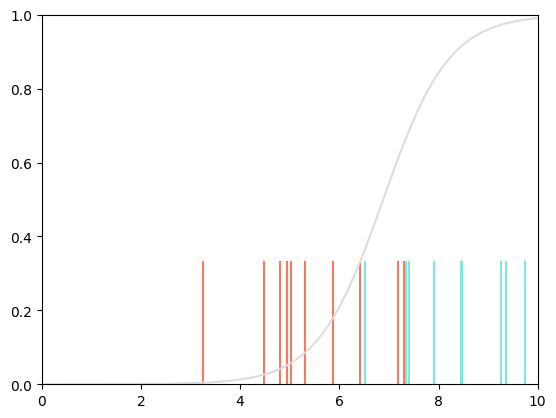

Updating generator
Initial generator loss =  2.886814198860462
Final generator loss =  5.213479183913634


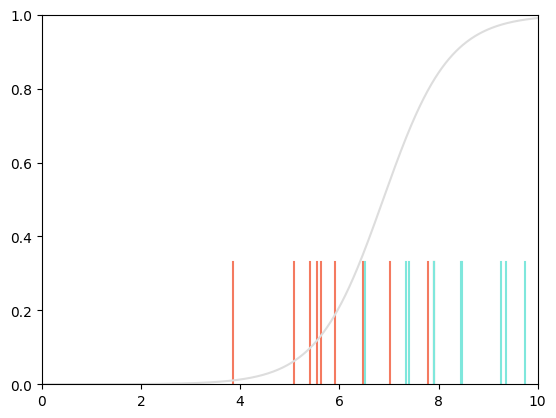

Updating discriminator
Initial discriminator loss =  7.630354725562823
Final Discriminator Loss=  7.330626495434425


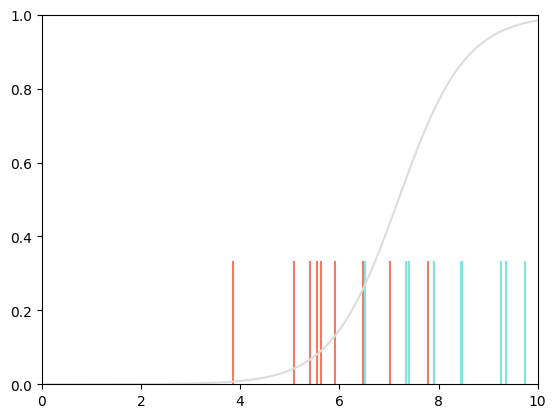

Updating generator
Initial generator loss =  3.895840531211491
Final generator loss =  6.622544243927747


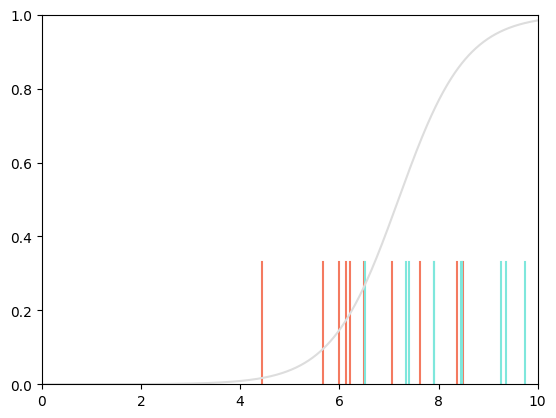

Updating discriminator
Initial discriminator loss =  10.057330208150681
Final Discriminator Loss=  9.753877188680672


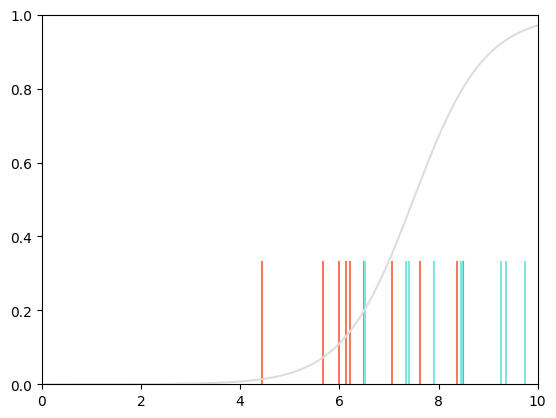

Updating generator
Initial generator loss =  5.06005872826842
Final generator loss =  7.962831225606431


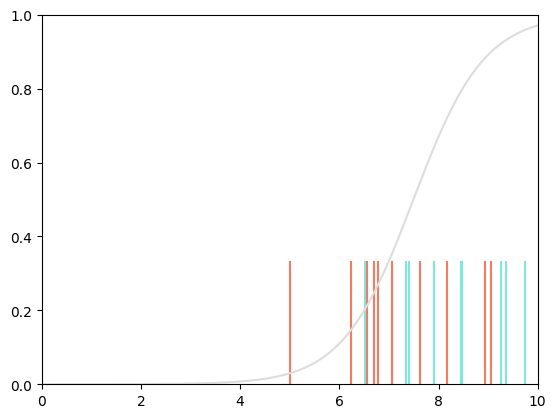

Updating discriminator
Initial discriminator loss =  12.656649686018683
Final Discriminator Loss=  14.747915073031002


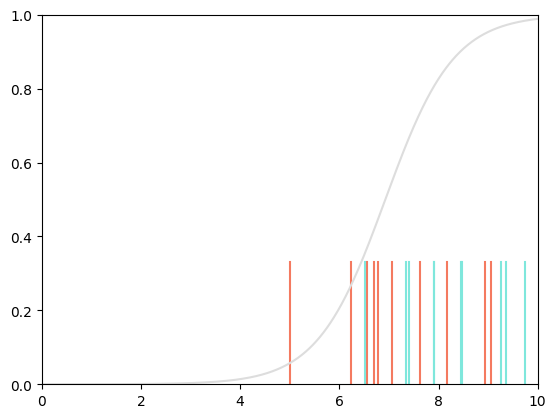

Updating generator
Initial generator loss =  12.162006117238409
Final generator loss =  17.479670997294583


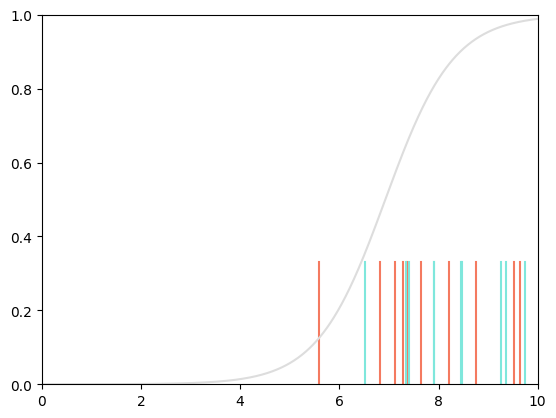

Updating discriminator
Initial discriminator loss =  20.065579953087177
Final Discriminator Loss=  25.622576462395156


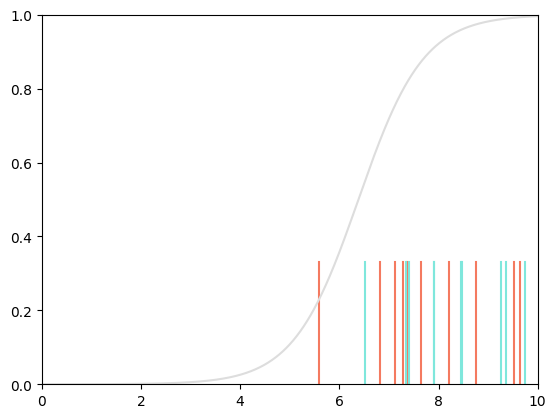

Updating generator
Initial generator loss =  24.328408917617022
Final generator loss =  32.21462995285782


In [20]:
# Now let's define a full GAN loop

# Initialize the parameters
theta = 3
phi0 = -2
phi1 = 1

# Number of iterations for updating generator and discriminator
n_iter_discrim = 300
n_iter_gen = 2

print("Final parameters (phi0,phi1)", phi0, phi1)
for c_gan_iter in range(10):

  # Run generator to product synthesized data
  x_syn = generator(z, theta)
  draw_data_model(x_real, x_syn, phi0, phi1)

  # Update the discriminator
  print("Updating discriminator")
  phi0, phi1 = update_discriminator(x_real, x_syn, n_iter_discrim, phi0, phi1)
  draw_data_model(x_real, x_syn, phi0, phi1)

  # Update the generator
  print("Updating generator")
  theta = update_generator(z, theta, n_iter_gen, phi0, phi1)


You can see that the synthesized data (orange) is becoming closer to the true data (cyan).  However, this is extremely unstable -- as you will find if you mess around with the number of iterations of each optimization and the total iterations overall.